In [1]:
#v1
#26/10/2018

dataname="melanoma_png_8"
pytable_root = '/mnt/ccipd_home/yxz1826/Skin/pytable'


ignore_index = 0    #Unet has the possibility of masking out pixels in the output image, we can specify the index value here (though not used)
gpuid=1

# --- unet params
#these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes= 3    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 5       #depth of the network 
wf= 6           #wf (int): number of filters in the first layer is 2**wf
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=3
patch_size=256
num_epochs = 100
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

import PIL
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

import scipy.ndimage

from tensorboardX import SummaryWriter

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix

In [3]:
#helper function for pretty printing of current time and remaining time
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent+.00001)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [4]:
#specify if we should use a GPU (cuda) or only the CPU
print(torch.cuda.get_device_properties(gpuid))
torch.cuda.set_device(gpuid)
device = torch.device(f'cuda:{gpuid}' if torch.cuda.is_available() else 'cpu')

_CudaDeviceProperties(name='Tesla K20c', major=3, minor=5, total_memory=5061MB, multi_processor_count=13)


In [5]:
#build the model according to the paramters specified above and copy it to the GPU. finally print out the number of trainable parameters
model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	31043651


In [6]:
#this defines our dataset class which will be used by the dataloader
class Dataset(object):
    def __init__(self, fname ,img_transform=None, mask_transform = None, edge_weight= False):
        #nothing special here, just internalizing the constructor parameters
        self.fname=fname
        self.edge_weight = edge_weight
        
        self.img_transform=img_transform
        self.mask_transform = mask_transform
        
        self.tables=tables.open_file(self.fname)
        self.numpixels=self.tables.root.numpixels[:]
        #print(self.fname)
        self.nitems=self.tables.root.img.shape[0]
        self.tables.close()
        
        self.img = None
        self.mask = None
    def __getitem__(self, index):
        #opening should be done in __init__ but seems to be
        #an issue with multithreading so doing here
        if(self.img is None): #open in thread
            self.tables=tables.open_file(self.fname)
            self.img=self.tables.root.img
            self.mask=self.tables.root.mask
       
        #get the requested image and mask from the pytable
        img = self.img[index,:,:,:]
        mask = self.mask[index,:,:]
        
        #the original Unet paper assignes increased weights to the edges of the annotated objects
        #their method is more sophistocated, but this one is faster, we simply dilate the mask and 
        #highlight all the pixels which were "added"
        if(self.edge_weight):
            weight = scipy.ndimage.morphology.binary_dilation(mask==1, iterations =2) & ~mask
        else: #otherwise the edge weight is all ones and thus has no affect
            weight = np.ones(mask.shape,dtype=mask.dtype)
        
        mask = mask[:,:,None].repeat(3,axis=2) #in order to use the transformations given by torchvision
        weight = weight[:,:,None].repeat(3,axis=2) #inputs need to be 3D, so here we convert from 1d to 3d by repetition
        
        img_new = img
        mask_new = mask
        weight_new = weight
        
        seed = random.randrange(sys.maxsize) #get a random seed so that we can reproducibly do the transofrmations
        if self.img_transform is not None:
            random.seed(seed) # apply this seed to img transforms
            img_new = self.img_transform(img)

        if self.mask_transform is not None:
            random.seed(seed)
            mask_new = self.mask_transform(mask)
            mask_new = np.asarray(mask_new)[:,:,0].squeeze()
            
            random.seed(seed)
            weight_new = self.mask_transform(weight)
            weight_new = np.asarray(weight_new)[:,:,0].squeeze()

        return img_new, mask_new, weight_new
    def __len__(self):
        return self.nitems

In [7]:
#note that since we need the transofrmations to be reproducible for both masks and images
#we do the spatial transformations first, and afterwards do any color augmentations
img_transform = transforms.Compose([
     transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    transforms.RandomGrayscale(),
    transforms.ToTensor()
    ])


mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    transforms.RandomRotation(180),
    ])



In [8]:



dataset={}
dataLoader={}
for phase in phases: #now for each of the phases, we're creating the dataloader
                     #interestingly, given the batch size, i've not seen any improvements from using a num_workers>0
    print(phase)
    dataset[phase]=Dataset(f"{pytable_root}/{dataname}_{phase}.pytable", img_transform=img_transform , mask_transform = mask_transform ,edge_weight=edge_weight)
    dataLoader[phase]=DataLoader(dataset[phase], batch_size=batch_size, 
                                shuffle=True, num_workers=0, pin_memory=True) 


train
val


0


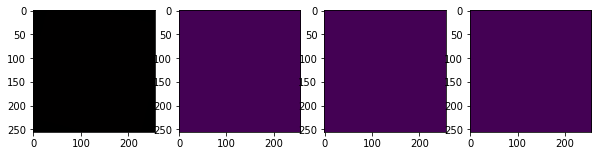

In [9]:
#visualize a single example to verify that it is correct
(img,patch_mask,patch_mask_weight)=dataset["train"][19995]
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns
print(patch_mask.max())
#build output showing original patch  (after augmentation), class = 1 mask, weighting mask, overall mask (to see any ignored classes)
ax[0].imshow(np.moveaxis(img.numpy(),0,-1))
ax[1].imshow(patch_mask==3)
ax[2].imshow(patch_mask_weight)
ax[3].imshow(patch_mask)

In [10]:
optim = torch.optim.Adam(model.parameters()) #adam is going to be the most robust, though perhaps not the best performing, typically a good place to start
# optim = torch.optim.SGD(model.parameters(),
#                           lr=.1,
#                           momentum=0.9,
#                           weight_decay=0.0005)

In [11]:
#we have the ability to weight individual classes, in this case we'll do so based on their presense in the trainingset
#to avoid biasing any particular class
nclasses = dataset["train"].numpixels.shape[1]
class_weight=dataset["train"].numpixels[1,1:nclasses] #don't take ignored class into account here
class_weight = torch.from_numpy(1-class_weight/class_weight.sum()).type('torch.FloatTensor').to(device)

print(class_weight) #show final used weights, make sure that they're reasonable before continouing
criterion = nn.CrossEntropyLoss(ignore_index = ignore_index ,reduce=None) #reduce = False makes sure we get a 2D output instead of a 1D "summary" value
print("numclass",nclasses)
print("ignore",ignore_index)

tensor([0.0054, 0.9946], device='cuda:1')
numclass 4
ignore 0


In [12]:
writer=SummaryWriter() #open the tensorboard visualiser
best_loss_on_test = np.Infinity

start_time = time.time()
for epoch in range(num_epochs):
    #zero out epoch based performance variables 
    all_acc = {key: 0 for key in phases} 
    all_loss = {key: np.zeros(None) for key in phases}
    cmatrix = {key: np.zeros((numclass,numclass)) for key in phases}
    
    for phase in phases: #iterate through both training and validation states
                    
        if phase == 'train':
            model.train()  # Set model to training mode
        else: #when in eval mode, we don't want parameters to be updated
            model.eval()   # Set model to evaluate mode

        for ii , (X, y, y_weight) in enumerate(dataLoader[phase]): #for each of the batches
            X = X.to(device)  # [Nbatch, 3, H, W]
            y = y.type('torch.LongTensor').to(device)  # [Nbatch, H, W] with class indices (0, 1)
            
            with torch.set_grad_enabled(phase == 'train'): #dynamically set gradient computation, in case of validation, this isn't needed
                                                            #disabling is good practice and improves inference time

                prediction = model(X)  # [N, Nclass, H, W]
                #print(type(criterion(prediction, y)))
                loss_matrix = criterion(prediction, y)
                
                loss = (loss_matrix * (edge_weight**y_weight).type('torch.cuda.FloatTensor')).mean() #debug.mean() #can skip if edge weight==1
                torch.cuda.synchronize()
                if phase=="train": #in case we're in train mode, need to do back propogation
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    train_loss = loss

                    
                all_loss[phase] = np.append(all_loss[phase], loss.detach().cpu().numpy()) #always add loss

                if phase in validation_phases: #if this phase is part of validation, compute confusion matrix
                    p=prediction[:,:,:,:].squeeze().detach().cpu().numpy()
                    cpredflat=np.argmax(p,axis=1).flatten()
                    yflat=y.cpu().numpy().flatten()

                    cmatrix[phase]=cmatrix[phase]+confusion_matrix(yflat,cpredflat)

        all_acc[phase]=(cmatrix[phase]/cmatrix[phase].sum()).trace()
        all_loss[phase] = all_loss[phase].mean()

        #save metrics to tensorboard
        writer.add_scalar(f'{phase}/loss', all_loss[phase], epoch)
        if phase in validation_phases:
            writer.add_scalar(f'{phase}/acc', all_acc[phase], epoch)
            writer.add_scalar(f'{phase}/TN', cmatrix[phase][0,0], epoch)
            writer.add_scalar(f'{phase}/TP', cmatrix[phase][1,1], epoch)
            writer.add_scalar(f'{phase}/FP', cmatrix[phase][0,1], epoch)
            writer.add_scalar(f'{phase}/FN', cmatrix[phase][1,0], epoch)
            writer.add_scalar(f'{phase}/TNR', cmatrix[phase][0,0]/(cmatrix[phase][0,0]+cmatrix[phase][0,1]), epoch)
            writer.add_scalar(f'{phase}/TPR', cmatrix[phase][1,1]/(cmatrix[phase][1,1]+cmatrix[phase][1,0]), epoch)
                
    print('%s ([%d/%d] %d%%), train loss: %.4f test loss: %.4f' % (timeSince(start_time, (epoch+1) / num_epochs), 
                                                 epoch+1, num_epochs ,(epoch+1) / num_epochs * 100, all_loss["train"], all_loss["val"]),end="")    

    #if current loss is the best we've seen, save model state with all variables
    #necessary for recreation
    if all_loss["val"] < best_loss_on_test:
        best_loss_on_test = all_loss["val"]
        print("  **")
        state = {'epoch': epoch + 1,
         'model_dict': model.state_dict(),
         'optim_dict': optim.state_dict(),
         'best_loss_on_test': all_loss,
         'n_classes': n_classes,
         'in_channels': in_channels,
         'padding': padding,
         'depth': depth,
         'wf': wf,
         'up_mode': up_mode, 'batch_norm': batch_norm}

        
        torch.save(state, f"{dataname}_unet_best_model.pth")
    else:
        print("")
        

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorCopy.cpp:20

In [16]:
stream
#At this stage, training is done...below are snippets to help with other tasks: output generation + visualization 

NameError: name 'stream' is not defined

In [88]:
#----- generate output
#load best model
checkpoint = torch.load(f"{dataname}_unet_best_model.pth")
model.load_state_dict(checkpoint["model_dict"])

In [89]:
#grab a single image from validation set
[img,mask,mask_weight]=dataset["val"][2]

In [90]:
#generate its output
#%%timeit
output=model(img[None,::].to(device))
output=output.detach().squeeze().cpu().numpy()
output=np.moveaxis(output,0,-1) 
output.shape

(256, 256, 2)

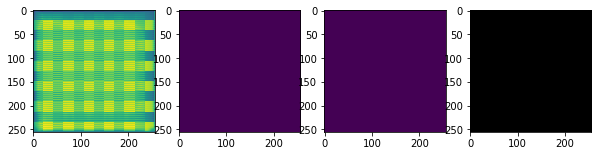

In [91]:
#visualize its result
fig, ax = plt.subplots(1,4, figsize=(10,4))  # 1 row, 2 columns

ax[0].imshow(output[:,:,1])
ax[1].imshow(np.argmax(output,axis=2))
ax[2].imshow(mask)
ax[3].imshow(np.moveaxis(img.numpy(),0,-1))


In [ ]:
#------- visualize kernels and activations

In [ ]:
#helper function for visualization
def plot_kernels(tensor, num_cols=8 ,cmap="gray"):
    if not len(tensor.shape)==4:
        raise Exception("assumes a 4D tensor")
#    if not tensor.shape[1]==3:
#        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0] * tensor.shape[1]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    i=0
    t=tensor.data.numpy()
    for t1 in t:
        for t2 in t1:
            i+=1
            ax1 = fig.add_subplot(num_rows,num_cols,i)
            ax1.imshow(t2 , cmap=cmap)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [ ]:
class LayerActivations():
    features=None
    def __init__(self,layer):
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    def remove(self):
        self.hook.remove()

In [ ]:
# --- visualize kernels

In [ ]:
w=model.up_path[2].conv_block.block[3]
plot_kernels(w.weight.detach().cpu(),8)

In [ ]:
# ---- visualize activiations

In [ ]:
dr=LayerActivations(model.up_path[2].conv_block.block[3])

In [ ]:
[img,mask,mask_weight]=dataset["val"][7]
plt.imshow(np.moveaxis(img.numpy(),0,-1))
output=model(img[None,::].to(device))
plot_kernels(dr.features,8,cmap="rainbow")

In [28]:
npixels

NameError: name 'npixels' is not defined

In [ ]:
## ---- Improvements:
#1 replace Adam with SGD with appropriate learning rate reduction
